In [1]:
import spotiphy
import numpy as np
import matplotlib as mpl
import scanpy as sc
import squidpy as sq
import importlib as imp
imp.reload(spotiphy)
imp.reload(spotiphy.segmentation)
imp.reload(spotiphy.sc_reference)

<module 'spotiphy.sc_reference' from 'C:\\Users\\zzheng92\\Desktop\\Spotiphy\\spotiphy\\sc_reference.py'>

In [2]:
adata_sc = sc.read_h5ad("F:/Ziqian Zheng/Spatial omics/Public dataset/scRNA/scRNA.h5ad")
adata_st = sc.read_visium("F:/Ziqian Zheng/Spotiphy_data/ST/Sample221/outs")
adata_st.var_names_make_unique()
results_folder = 'results/221_160k/'
key_type = 'Allen.subclass_label'
type_list = sorted(list(adata_sc.obs[key_type].unique()))

anndata.py (1832): Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Image.py (3176): Image size (99010000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.


In [3]:
adata_sc_orig = sc.read_h5ad("F:/Ziqian Zheng/Spatial omics/Public dataset/scRNA/scRNA.h5ad")
adata_st_orig = sc.read_visium("F:/Ziqian Zheng/Spotiphy_data/ST/Sample221/outs")
adata_st_orig.var_names_make_unique()

anndata.py (1832): Variable names are not unique. To make them unique, call `.var_names_make_unique`.


In [4]:
img = sq.im.ImageContainer('F:/Ziqian Zheng/Spotiphy_data/ST/Sample221/Sample221.jpg')
Segmentation = spotiphy.segmentation.Segmentation(img['image'][:, :, 0], adata_st.obsm['spatial'], out_dir=results_folder)
Segmentation.segment_nucleus(save=False)
adata_st.obs[Segmentation.n_cell_df.columns] = Segmentation.n_cell_df.values
adata_st_orig.obs['cell_count'] = Segmentation.n_cell_df['cell_count'].values

Suppress the output of tensorflow prediction for tensorflow version 2.12.0>=2.9.0.
Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


100%|██████████| 36/36 [01:07<00:00,  1.89s/it]


In [5]:
%%time
adata_sc, adata_st = spotiphy.initialization(adata_sc, adata_st)

CPU times: total: 2min 47s
Wall time: 2min 47s


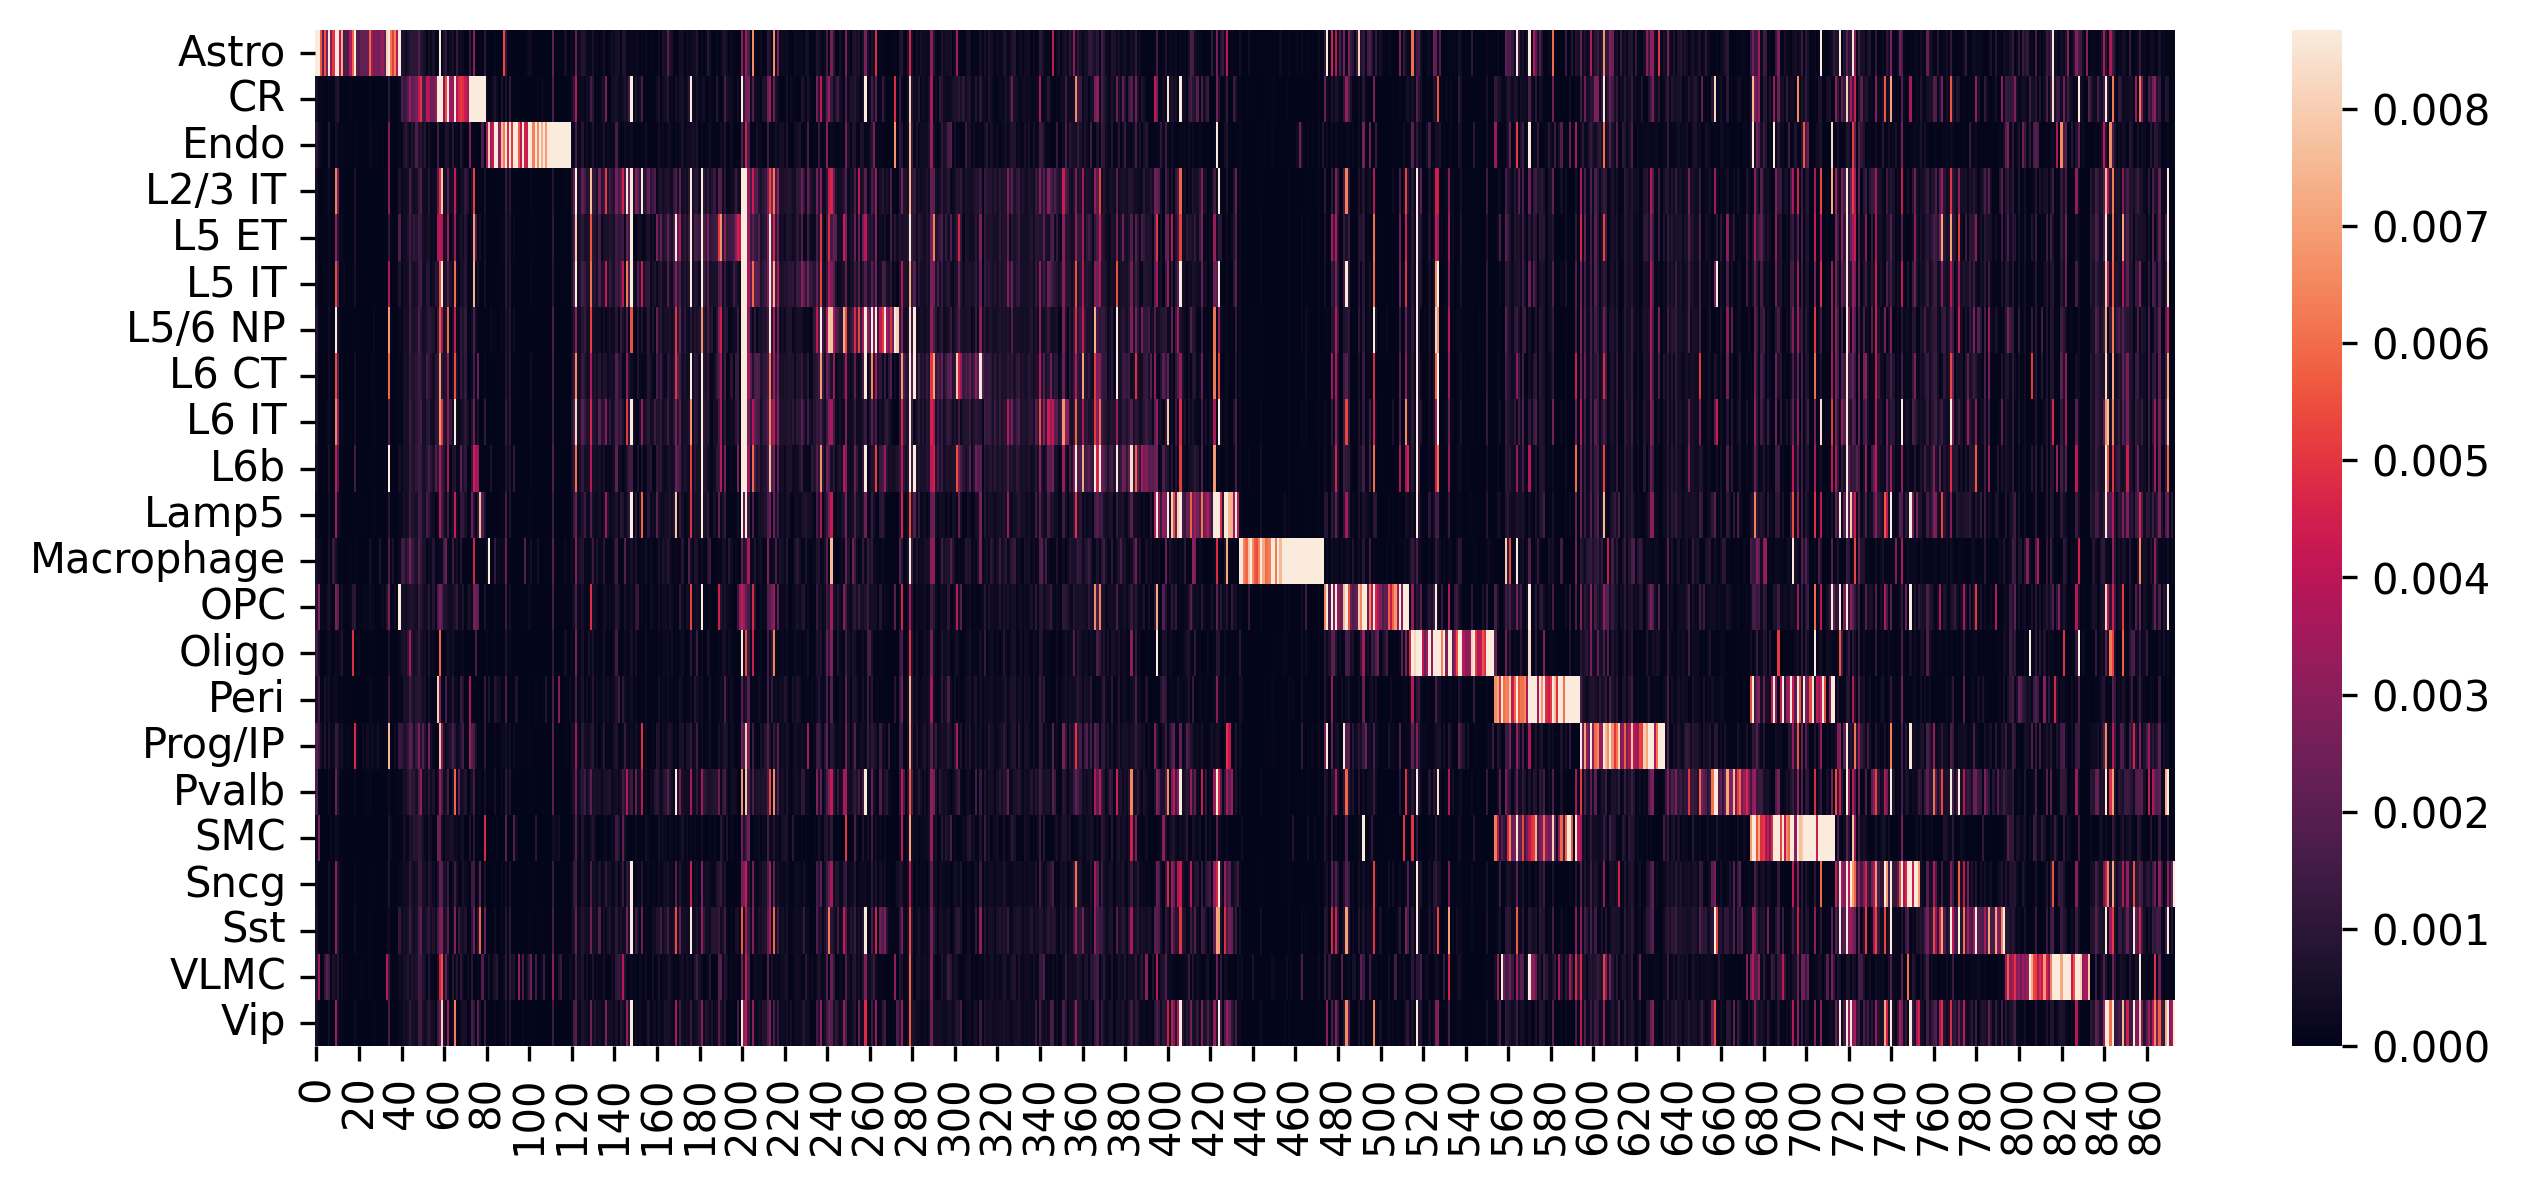

CPU times: total: 2min 51s
Wall time: 2min 51s


In [6]:
%%time
marker_gene = spotiphy.marker_selection(adata_sc, key_type=key_type, return_dict=False, n_select=40)
adata_sc = adata_sc[:, marker_gene]
adata_st = adata_st[:, marker_gene]
sc_ref = spotiphy.construct_sc_ref(adata_sc, key_type=key_type)
spotiphy.plot_sc_ref(sc_ref, type_list)

In [7]:
X = np.array(adata_st.X)
pyro_params = spotiphy.deconvolution.deconvolute(X, sc_ref)

 16%|█▋        | 1311/8000 [00:54<03:16, 34.08it/s]

In [8]:
sigma = pyro_params['sigma'].cpu().detach().numpy()
mean_exp = np.array([np.mean(np.sum(adata_sc.X[adata_sc.obs[key_type]==type_list[i]], axis=1)) for i in range(len(type_list))])
cell_proportion = sigma/mean_exp
cell_proportion = cell_proportion/np.sum(cell_proportion, axis=1)[:, np.newaxis]
adata_st.obs[type_list] = cell_proportion
np.save(results_folder+'proportion.npy', cell_proportion)

In [6]:
%%time
imp.reload(spotiphy.deconvolution)
cell_proportion = np.load(results_folder+'proportion.npy')
adata_st_new = spotiphy.deconvolution.simulation(adata_st_orig, adata_sc_orig, key_type, cell_proportion,
                                                 n_cell='cell_count', save=True, out_dir=results_folder)

_index.py (137): Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.


3


anndata.py (1222): Trying to modify attribute `.var` of view, initializing view as actual.
anndata.py (1222): Trying to modify attribute `.var` of view, initializing view as actual.


CPU times: total: 1min 49s
Wall time: 1min 49s


In [7]:
adata_st_new.X.sum(axis=1)

matrix([[2838427.5],
        [3502462.5],
        [2903377.8],
        ...,
        [4874516.5],
        [ 726126.6],
        [ 683147.2]], dtype=float32)